Utilização da biblioteca AutoTS.

In [13]:
# Importa bibliotecas; inicializa variáveis; define funções.
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
import auto_ts as AT
import math as mt
from sklearn.metrics import mean_squared_error
import seaborn as sns

colunas = ['data','total','ibc','pib','consumo', 'ICST-R', 'geracaoGWh','IndGeral']

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

dados_autoML = pd.read_csv('dadosRonaldo.csv')
dados_autoML.head()

df = dados_autoML[colunas]
df = df.set_index('data')
df.index = pd.to_datetime(df.index)

df.info()

print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().any())
print ("\nUnique values :  \n",df.nunique())

df

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 84 entries, 2014-01-01 to 2020-12-01
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   total       84 non-null     int64  
 1   ibc         84 non-null     float64
 2   pib         84 non-null     float64
 3   consumo     84 non-null     float64
 4   ICST-R      84 non-null     float64
 5   geracaoGWh  84 non-null     float64
 6   IndGeral    84 non-null     float64
dtypes: float64(6), int64(1)
memory usage: 5.2 KB
Rows     :  84
Columns  :  7

Features : 
 ['total', 'ibc', 'pib', 'consumo', 'ICST-R', 'geracaoGWh', 'IndGeral']

Missing values :   total         False
ibc           False
pib           False
consumo       False
ICST-R        False
geracaoGWh    False
IndGeral      False
dtype: bool

Unique values :  
 total         84
ibc           79
pib           84
consumo       72
ICST-R        73
geracaoGWh    84
IndGeral      74
dtype: int64


,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
data,,,,,,,
2014-01-01,13427897,2.75,455935.0,4.027976e+07,97.8,50045.962407,53.1
2014-02-01,14152120,3.13,450358.8,4.165349e+07,96.7,46459.730274,52.3
2014-03-01,13710770,3.09,462159.8,4.026943e+07,96.3,48004.277170,52.4
2014-04-01,12602895,2.37,468767.5,3.959185e+07,92.6,45412.583753,49.2
2014-05-01,14603442,2.23,473347.1,3.910050e+07,94.6,44890.282526,47.9
...,...,...,...,...,...,...,...
2020-08-01,33983713,-3.35,628818.8,3.912152e+07,87.8,45954.347797,57.0
2020-09-01,32205815,-3.56,632047.2,4.020856e+07,91.5,46045.040560,61.6
2020-10-01,33749277,-3.94,660199.5,4.245064e+07,95.2,46098.056273,61.8


Explorando o conjunto de dados utilizados.

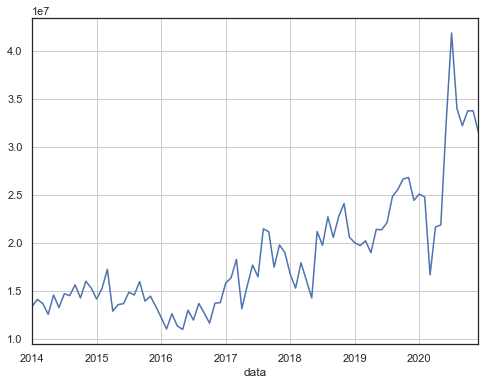

In [8]:
ec_df = df
ec_data = ec_df['total']
ec_data.head()
df.describe()
ec_data.plot(grid=True)

Vamos avaliar o funcionamento da AutoTS, utilizando os dados de 2014 até 2019 para prever o 'total' em 2020. 

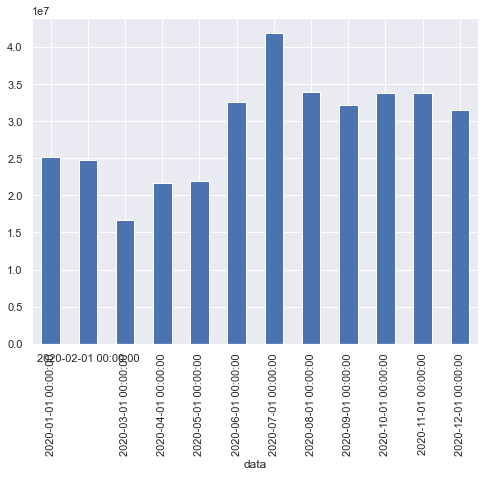

In [20]:
ec_df_2020=ec_df.loc['2020']
ec_data_2020=ec_df_2020['total']
ec_data_2020.plot(grid=True)
ec_data_2020.plot.bar()

In [12]:
final_df = df.copy()
final_df=final_df.reset_index()
final_df=final_df[colunas]

final_df.head(10)

,data,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
0,2014-01-01,13427897,2.75,455935.0,40279759.00,97.8,50045.962407,53.1
1,2014-02-01,14152120,3.13,450358.8,41653487.00,96.7,46459.730274,52.3
2,2014-03-01,13710770,3.09,462159.8,40269429.00,96.3,48004.277170,52.4
3,2014-04-01,12602895,2.37,468767.5,39591854.00,92.6,45412.583753,49.2
4,2014-05-01,14603442,2.23,473347.1,39100499.00,94.6,44890.282526,47.9
5,2014-06-01,13296350,1.85,458516.5,37726472.88,93.1,41970.305389,47.4
6,2014-07-01,14742923,1.45,481994.0,37866809.00,91.6,42991.945569,46.4
7,2014-08-01,14540126,1.13,477052.9,38550694.00,92.0,42636.899277,46.5
8,2014-09-01,15667226,0.85,476520.6,38894976.00,90.5,43171.224770,46.5
9,2014-10-01,14301399,0.49,493304.7,40100440.59,88.0,46186.817965,45.8


Preparando os conjuntos de treino e teste; também outros parâmetros usado pelo AutoTS.

In [21]:
traindata = final_df[:72]
testdata = final_df[72:84]

ts_column = 'data'
sep = ','
target = 'total'
print(traindata.shape, testdata.shape)

(72, 8) (12, 8)


In [22]:
# Dados de treino.
traindata.head()

,data,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
0,2014-01-01,13427897,2.75,455935.0,40279759.0,97.8,50045.962407,53.1
1,2014-02-01,14152120,3.13,450358.8,41653487.0,96.7,46459.730274,52.3
2,2014-03-01,13710770,3.09,462159.8,40269429.0,96.3,48004.277170,52.4
3,2014-04-01,12602895,2.37,468767.5,39591854.0,92.6,45412.583753,49.2
4,2014-05-01,14603442,2.23,473347.1,39100499.0,94.6,44890.282526,47.9


In [23]:
# Dados de teste.
testdata.head()

,data,total,ibc,pib,consumo,ICST-R,geracaoGWh,IndGeral
72,2020-01-01,25113021,0.91,617701.0,41184302.53,94.2,50862.73416,65.3
73,2020-02-01,24799556,0.73,609810.8,40750716.72,92.8,47820.78192,64.7
74,2020-03-01,16697718,0.75,616351.2,40989914.14,90.8,49069.64952,60.3
75,2020-04-01,21669098,-0.51,545941.7,37130625.61,65.0,41010.99120,34.5
76,2020-05-01,21893223,-2.11,559345.4,36105010.23,68.0,41437.50408,34.7


Rodando o AutoTS: ferramenta realizando o set inicial e o fit. 

"WARNING: Running best models will take time... Be Patient..." <= Aviso da ferramenta...

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |     -1.8110599224858244      |
|           p-value           |     0.37498473849007014      |
|          #Lags Used         |             0.0              |
| Number of Observations Used |             71.0             |
|     Critical Value (1%)     |      -3.526004646825607      |
|     Critical Value (5%)     |     -2.9032002348069774      |
|     Critical Value (10%)    |     -2.5889948363419957      |
+-----------------------------+------------------------------+
 this series is non-stationary. Trying test again after differencing...
After differencing=1, results of Augmented Dickey-Fuller Test:
+-----------------

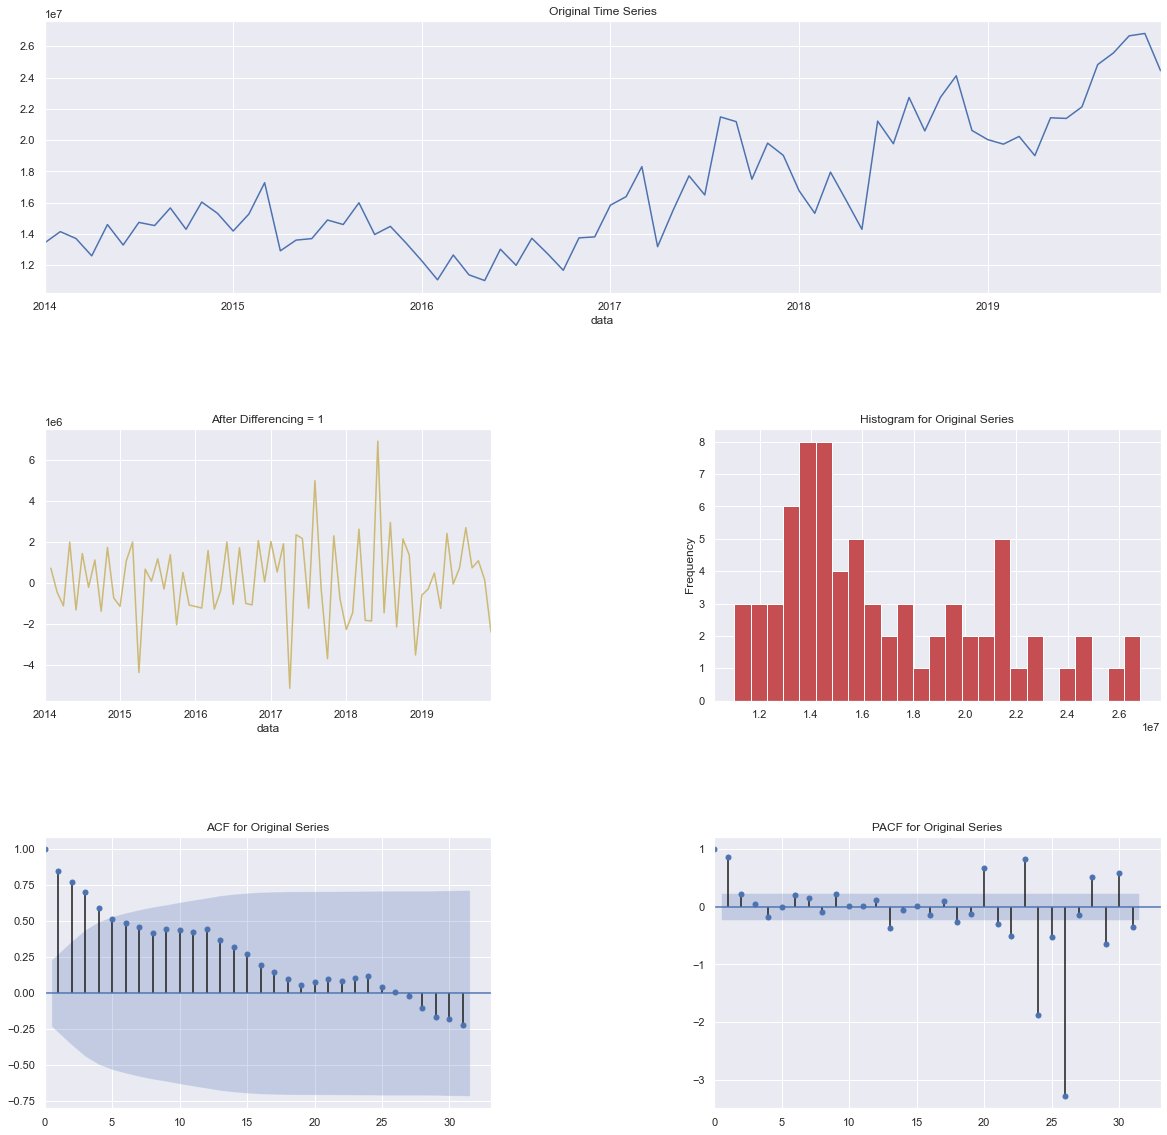

Time Interval is given as M
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(72, 8)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=12, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 47 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 3,995,467.58
    Std Deviation of actuals = 1,311,594.35
    Normalized RMSE = 305%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 52 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 4,215,715.30
    Std Deviation of actuals = 2,878,829.99
    Normalized RMSE = 146%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 57 Test Shape: 5
    Root Mean Squared Error predictions vs actua

 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=1797.346, Time=0.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=1802.433, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=1980.597, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=1803.508, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=1793.601, Time=0.66 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=1795.477, Time=1.20 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=1795.487, Time=0.64 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=1796.043, Time=0.35 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=1797.473, Time=2.05 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=1798.599, Time=0.61 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=1795.934, Time=1.18 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=1795.915, Time=0.73 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=1795.043, Time=0.52 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=1797.907, Time=0.64 sec
 ARIMA(1,0,0)(2,0,0)[12]             : AIC=1791.593, Time=0.47

 ARIMA(1,0,0)(3,0,1)[12]             : AIC=2267.594, Time=1.88 sec
 ARIMA(0,0,0)(2,0,0)[12]             : AIC=2273.851, Time=0.20 sec
 ARIMA(2,0,0)(2,0,0)[12]             : AIC=2266.439, Time=0.37 sec
 ARIMA(1,0,1)(2,0,0)[12]             : AIC=2266.376, Time=0.49 sec
 ARIMA(0,0,1)(2,0,0)[12]             : AIC=2267.214, Time=0.26 sec
 ARIMA(2,0,1)(2,0,0)[12]             : AIC=2267.776, Time=0.75 sec

Best model:  ARIMA(1,0,0)(2,0,0)[12]          
Total fit time: 15.354 seconds

Best model is a Seasonal SARIMAX(1,0,0)*(2,0,0,12), aic = 2264.160
Refitting data with previously found best parameters
    Best aic metric = 1482.5
                                     SARIMAX Results                                      
Dep. Variable:                              total   No. Observations:                   72
Model:             SARIMAX(1, 0, 0)x(2, 0, 0, 12)   Log Likelihood                -729.235
Date:                            Fri, 11 Jun 2021   AIC                           1482.469
Time:

 Iteration 45 completed
 Iteration 46 completed
 Iteration 47 completed
 Iteration 48 completed
    Best AR order p = 2, MA order q = 0, Interim metric = 3152.578

Additional Variable in VAR model = ICST-R
 Iteration 49 completed
 Iteration 50 completed
 Iteration 51 completed
 Iteration 52 completed
 Iteration 53 completed
 Iteration 54 completed
 Iteration 55 completed
 Iteration 56 completed
 Iteration 57 completed
 Iteration 58 completed
 Iteration 59 completed
 Iteration 60 completed
 Iteration 61 completed
 Iteration 62 completed
 Iteration 63 completed
 Iteration 64 completed
    Best AR order p = 3, MA order q = 0, Interim metric = 1845.010

Additional Variable in VAR model = geracaoGWh
 Iteration 65 completed
 Iteration 66 completed
 Iteration 67 completed
 Iteration 68 completed
 Iteration 69 completed
 Iteration 70 completed
 Iteration 71 completed
 Iteration 72 completed
 Iteration 73 completed
 Iteration 74 completed
 Iteration 75 completed
 Iteration 76 completed
 Iterati

 Iteration 2 completed
 Iteration 3 completed
 Iteration 4 completed
 Iteration 5 completed
 Iteration 6 completed
 Iteration 7 completed
 Iteration 8 completed
 Iteration 9 completed
 Iteration 10 completed
 Iteration 11 completed
 Iteration 12 completed
 Iteration 13 completed
 Iteration 14 completed
 Iteration 15 completed
 Iteration 16 completed
    Best AR order p = 3, MA order q = 0, Interim metric = 2142.205

Additional Variable in VAR model = pib
 Iteration 17 completed
 Iteration 18 completed
 Iteration 19 completed
 Iteration 20 completed
 Iteration 21 completed
 Iteration 22 completed
 Iteration 23 completed
 Iteration 24 completed
 Iteration 25 completed
 Iteration 26 completed
 Iteration 27 completed
 Iteration 28 completed
 Iteration 29 completed
 Iteration 30 completed
 Iteration 31 completed
 Iteration 32 completed
    Best AR order p = 3, MA order q = 0, Interim metric = 3579.591

Additional Variable in VAR model = consumo
 Iteration 33 completed
 Iteration 34 complete

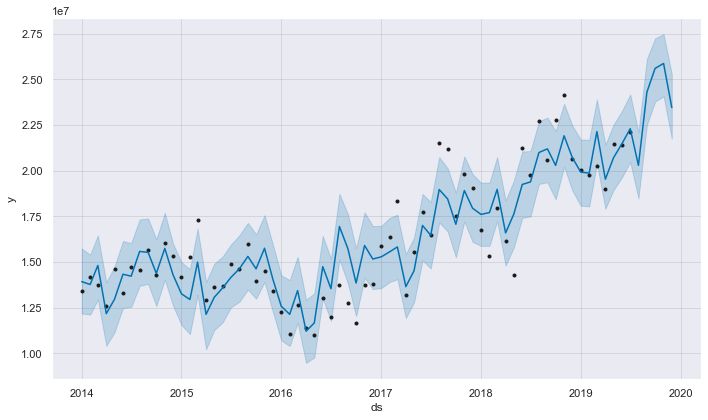

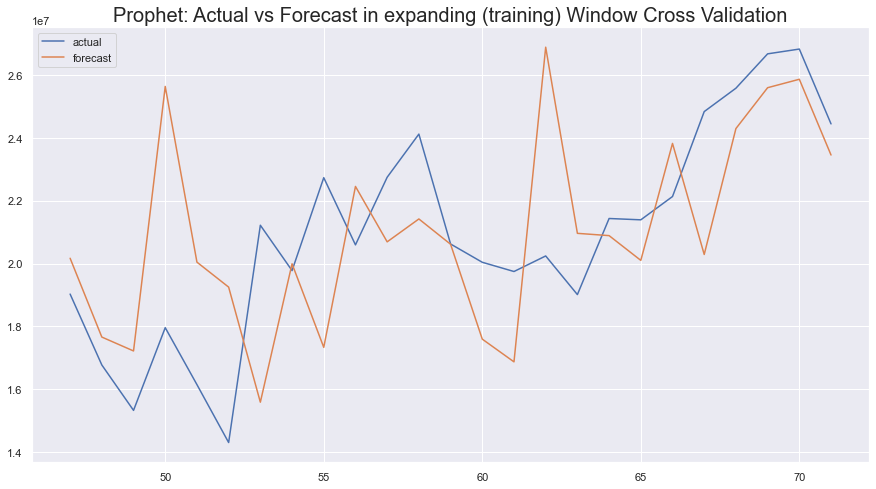

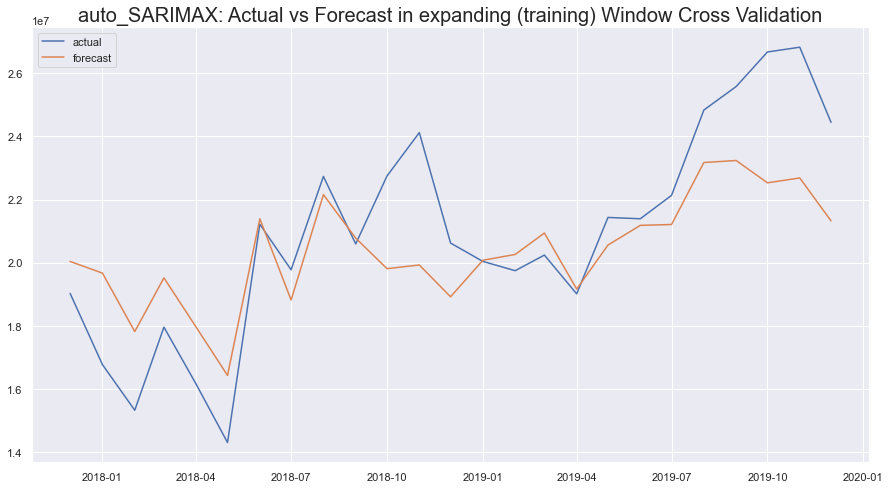

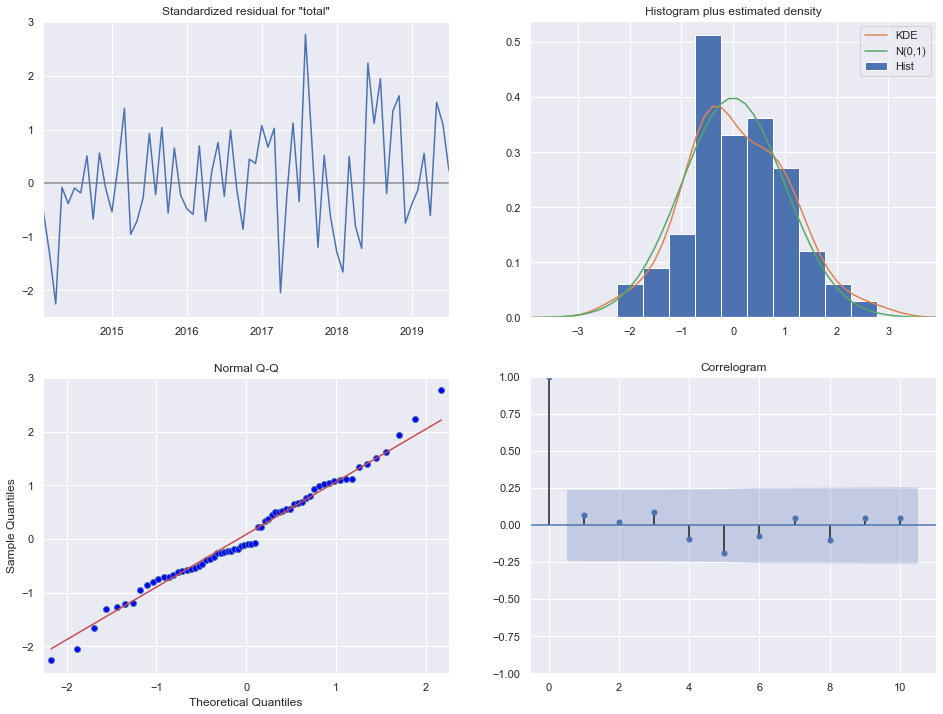

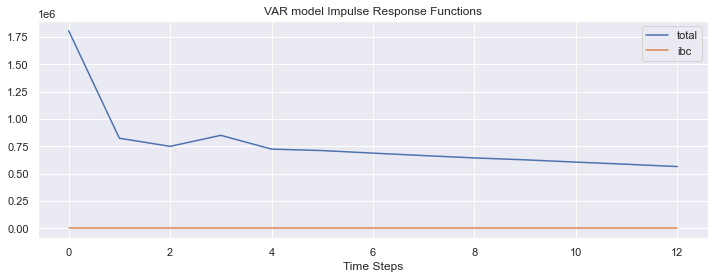

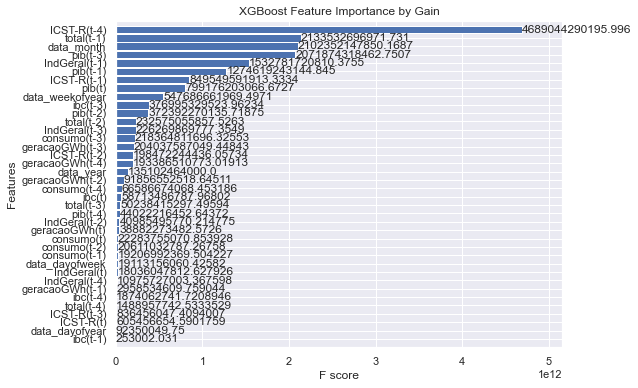

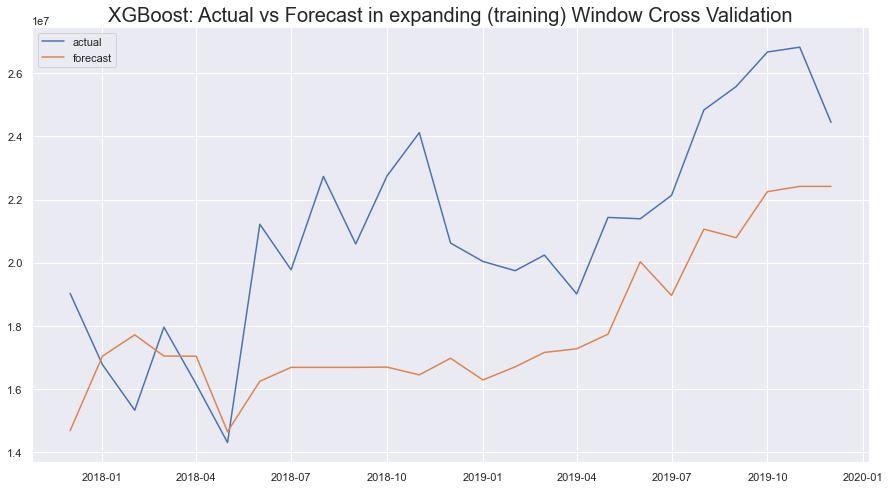

In [24]:
model = AT.auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=True, seasonal_period=12,
                model_type=['best'],
                verbose=2)
"""
Lista de Modelos permitidos (10): best, prophet, stats, ml, arima, ARIMA, 
                                    Prophet, SARIMAX, VAR, ML.
"""

model.fit(traindata, ts_column,target)

 A ferramenta ofereceu um ranking...
 
 Leaderboard with best model on top of list:
            name          rmse
1  auto_SARIMAX  1.892607e+06
0       Prophet  3.196887e+06
2           VAR  3.643377e+06
3            ML  3.671966e+06

Vamos detalhar os resultados do auto_SARIMAX.

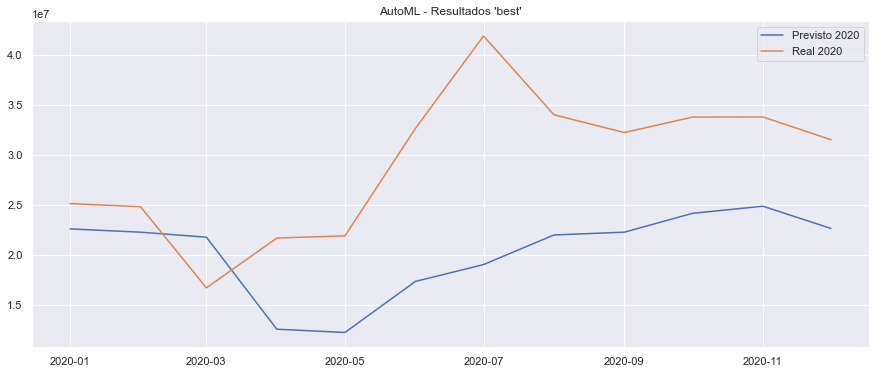

O valor do rmse é:  11037950.846192617


In [25]:
### Best => auto_SARIMAX
predicao = model.predict(testdata, model='best')
resultado = predicao.loc[:, ['yhat']]
resultado = resultado.reset_index()
resultado = resultado.rename(columns={'index': 'data'})

real = testdata.loc[:,['data', 'total']]

final_2020 = pd.merge(resultado, real, how = 'inner')
x = final_2020['data']
y1 = final_2020['yhat']
y2 =final_2020['total']

sns.set()
plt.figure(figsize=(15,6))
plt.title('AutoML - Resultados \'best\'')
plt.plot(x,y1,label="Previsto 2020")
plt.plot(x,y2,label="Real 2020")
plt.legend()
plt.show()

print('O valor do rmse é: ', \
          mt.sqrt(mean_squared_error(final_2020['yhat'], final_2020['total'])))